# Organizar de tal modo que no toque recalcular matrices!

### Links

* Speeding up Python: https://wiki.python.org/moin/PythonSpeed/PerformanceTips
* Check if a file exists: http://stackoverflow.com/questions/82831/check-whether-a-file-exists-using-python
* Markdown cheatsheet: https://github.com/adam-p/markdown-here/wiki/Markdown-Cheatsheet
* OpenCV Python Tutorials: https://opencv-python-tutroals.readthedocs.org/en/latest/
* Magic functions https://ipython.org/ipython-doc/dev/interactive/magics.html

### Utilities

```python
[n for n in dir(widgets) if not n.endswith('Widget') and n[0] == n[0].upper() and not n[0] == '_']

nms = dir(cv2) # list of everything in the cv2 module
[m for m in nms if 'PROP' in m]

help(cv2.adaptiveThreshold)
```

In [1]:
# -*- coding: utf-8 -*-
%matplotlib inline
import glob
import os
import re
import time as t

import cv2
import cv2.cv as cv
import IPython
from IPython.display import display
import ipywidgets as widgets
from matplotlib import pyplot as plt
import numpy as np

print "OpenCV version:   {}".format(cv2.__version__)
print "IPython version:  {}".format(IPython.__version__)

# i = cv2.imread('stereo1/sample.png')
# RESOLUTION = (i.shape[1], i.shape[0])
RESOLUTION = (640, 480)
grid_w = 7
grid_h = 7
GRID_SIZE = (grid_w, grid_h)
sq_size = 3 # cm
crit = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 30, 0.001)

objp = np.zeros((grid_w*grid_h,3), np.float32)
objp[:,:2] = np.mgrid[0:grid_w,0:grid_h].T.reshape(-1,2) * sq_size

OpenCV version:   2.4.11
IPython version:  4.0.0


In [2]:
def change_figsize(w, h):
    fig_size = plt.rcParams["figure.figsize"]
    fig_size = (w, h)
    plt.rcParams["figure.figsize"] = fig_size
    
def nothing(x):
    pass

change_figsize(18, 14)

In [3]:
imagesL = sorted(glob.glob("stereo1/img/set1/L*.png"))
imagesR = sorted(glob.glob("stereo1/img/set1/R*.png"))

objpoints = []
imgpoints1 = []
imgpoints2 = []

t_start = t.clock()

for fnameL, fnameR in zip(imagesL, imagesR):
    imgL = cv2.imread(fnameL)
    imgR = cv2.imread(fnameR)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    retL, cornersL = cv2.findChessboardCorners(grayL, GRID_SIZE)
    retR, cornersR = cv2.findChessboardCorners(grayR, GRID_SIZE)
        
    if retL is True and retR is True:
        objpoints.append(objp)
        cv2.cornerSubPix(grayL, cornersL, (11,11), (-1,-1), crit)
        cv2.cornerSubPix(grayR, cornersR, (11,11), (-1,-1), crit)
        imgpoints1.append(cornersL)
        imgpoints2.append(cornersR)
        ## Show chessboard corners in images:
        # cv2.drawChessboardCorners(imgL, GRID_SIZE, cornersL, retL)
        # cv2.drawChessboardCorners(imgR, GRID_SIZE, cornersR, retR)
        
    ## Show if corners had been detected for each image pair
    # print retL, fnameL
    # print retR, fnameR
    
    ## Show images:
    # imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    # imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)
    # plt.imshow(np.concatenate((imgL,imgR), axis=1))
    # plt.show()
retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpoints1, RESOLUTION)
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpoints2, RESOLUTION)

time = t.clock() - t_start

if not os.path.isfile("data/result_calib_set1.npz"):
    np.savez("data/result_calib_set1.npz", mtxL, distL, mtxR, distR)
if not os.path.isfile("data/points_calib_set1.npz"):
    np.savez("data/points_calib_set1.npz", objpoints, imgpoints1, imgpoints2)

print "Set 1 - {} images".format(len(imgpoints1))
print "\nRMS: {} {}".format(retL, retR)
print "Left camera matrix:\n{}".format(mtxL)
print "Left camera distortion coefficients:\n{}".format(distL.ravel())
print "\nRight camera matrix:\n{}".format(mtxR)
print "Right camera distortion coefficients:\n{}".format(distR.ravel())
print "\nCalculation time: {} seconds".format(time)

Set 1 - 18 images

RMS: 0.130180622258 0.126588057619
Left camera matrix:
[[  1.09230888e+03   0.00000000e+00   3.39416541e+02]
 [  0.00000000e+00   1.09265797e+03   2.34531098e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Left camera distortion coefficients:
[-0.11775283  0.10200727 -0.00118887 -0.00290651 -0.47635969]

Right camera matrix:
[[  1.09568734e+03   0.00000000e+00   3.31456124e+02]
 [  0.00000000e+00   1.09657559e+03   2.25777443e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Right camera distortion coefficients:
[ -7.85563528e-02  -5.79198730e-01  -4.03783806e-03  -2.46971597e-03
   3.47007633e+00]

Calculation time: 5.88692994886 seconds


In [4]:
imagesL = sorted(glob.glob("stereo1/img/set2/L*.png"))
imagesR = sorted(glob.glob("stereo1/img/set2/R*.png"))

objpoints = []
imgpoints1 = []
imgpoints2 = []

t_start = t.clock()

for fnameL, fnameR in zip(imagesL, imagesR):
    imgL = cv2.imread(fnameL)
    imgR = cv2.imread(fnameR)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    retL, cornersL = cv2.findChessboardCorners(grayL, GRID_SIZE)
    retR, cornersR = cv2.findChessboardCorners(grayR, GRID_SIZE)
        
    if retL is True and retR is True:
        objpoints.append(objp)
        cv2.cornerSubPix(grayL, cornersL, (11,11), (-1,-1), crit)
        cv2.cornerSubPix(grayR, cornersR, (11,11), (-1,-1), crit)
        imgpoints1.append(cornersL)
        imgpoints2.append(cornersR)
        ## Show chessboard corners in images:
        # cv2.drawChessboardCorners(imgL, GRID_SIZE, cornersL, retL)
        # cv2.drawChessboardCorners(imgR, GRID_SIZE, cornersR, retR)
        
    ## Show if corners had been detected for each image pair
    # print retL, fnameL
    # print retR, fnameR
    
    ## Show images:
    # imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    # imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)
    # plt.imshow(np.concatenate((imgL,imgR), axis=1))
    # plt.show()

retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpoints1, RESOLUTION)
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpoints2, RESOLUTION)

time = t.clock() - t_start

if not os.path.isfile("data/result_calib_set2.npz"):
    np.savez("data/result_calib_set2.npz", mtxL, distL, mtxR, distR)
if not os.path.isfile("data/points_calib_set2.npz"):
    np.savez("data/points_calib_set2.npz", objpoints, imgpoints1, imgpoints2)

print "Set 2 - {} images".format(len(imgpoints1))
print "\nRMS: {} {}".format(retL, retR)
print "Left camera matrix:\n{}".format(mtxL)
print "Left camera distortion coefficients:\n{}".format(distL.ravel())
print "\nRight camera matrix:\n{}".format(mtxR)
print "Right camera distortion coefficients:\n{}".format(distR.ravel())
print "\nCalculation time: {} seconds".format(time)

Set 2 - 18 images

RMS: 0.137837232119 0.140887460465
Left camera matrix:
[[  1.10794337e+03   0.00000000e+00   3.38002492e+02]
 [  0.00000000e+00   1.10855074e+03   2.43182478e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Left camera distortion coefficients:
[ -1.35205730e-01   3.70910191e-01  -1.71667132e-04  -3.49846170e-03
  -9.82188929e-01]

Right camera matrix:
[[  1.11049517e+03   0.00000000e+00   3.25127074e+02]
 [  0.00000000e+00   1.11191142e+03   2.35550128e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Right camera distortion coefficients:
[-0.12234184  0.3797341  -0.00150378 -0.00291876 -1.44473123]

Calculation time: 6.69344283924 seconds


In [5]:
imagesL = sorted(glob.glob("stereo1/img/set3/L*.png"))
imagesR = sorted(glob.glob("stereo1/img/set3/R*.png"))

objpoints = []
imgpoints1 = []
imgpoints2 = []

t_start = t.clock()

for fnameL, fnameR in zip(imagesL, imagesR):
    imgL = cv2.imread(fnameL)
    imgR = cv2.imread(fnameR)
    grayL = cv2.cvtColor(imgL, cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR, cv2.COLOR_BGR2GRAY)
    retL, cornersL = cv2.findChessboardCorners(grayL, GRID_SIZE)
    retR, cornersR = cv2.findChessboardCorners(grayR, GRID_SIZE)
        
    if retL is True and retR is True:
        objpoints.append(objp)
        cv2.cornerSubPix(grayL, cornersL, (11,11), (-1,-1), crit)
        cv2.cornerSubPix(grayR, cornersR, (11,11), (-1,-1), crit)
        imgpoints1.append(cornersL)
        imgpoints2.append(cornersR)
        ## Show chessboard corners in images:
        # cv2.drawChessboardCorners(imgL, GRID_SIZE, cornersL, retL)
        # cv2.drawChessboardCorners(imgR, GRID_SIZE, cornersR, retR)
        
    ## Show if corners had been detected for each image pair
    # print retL, fnameL
    # print retR, fnameR
    
    ## Show images:
    # imgL = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
    # imgR = cv2.cvtColor(imgR, cv2.COLOR_BGR2RGB)
    # plt.imshow(np.concatenate((imgL,imgR), axis=1))
    # plt.show()

retL, mtxL, distL, rvecsL, tvecsL = cv2.calibrateCamera(objpoints, imgpoints1, RESOLUTION)
retR, mtxR, distR, rvecsR, tvecsR = cv2.calibrateCamera(objpoints, imgpoints2, RESOLUTION)

time = t.clock() - t_start

if not os.path.isfile("data/result_calib_set3.npz"):
    np.savez("data/result_calib_set3.npz", mtxL, distL, mtxR, distR)
if not os.path.isfile("data/points_calib_set3.npz"):
    np.savez("data/points_calib_set3.npz", objpoints, imgpoints1, imgpoints2)

print "Set 3 - {} images".format(len(imgpoints1))
print "\nRMS: {} {}".format(retL, retR)
print "Left camera matrix:\n{}".format(mtxL)
print "Left camera distortion coefficients:\n{}".format(distL.ravel())
print "\nRight camera matrix:\n{}".format(mtxR)
print "Right camera distortion coefficients:\n{}".format(distR.ravel())
print "\nCalculation time: {} seconds".format(time)

Set 3 - 18 images

RMS: 0.136903844871 0.130967818308
Left camera matrix:
[[  1.10909242e+03   0.00000000e+00   3.45418462e+02]
 [  0.00000000e+00   1.10984903e+03   2.36193062e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Left camera distortion coefficients:
[ -1.53104943e-01   1.05552261e+00  -8.66432548e-04  -1.41840843e-03
  -5.54200317e+00]

Right camera matrix:
[[  1.11230402e+03   0.00000000e+00   3.31470371e+02]
 [  0.00000000e+00   1.11329271e+03   2.33020430e+02]
 [  0.00000000e+00   0.00000000e+00   1.00000000e+00]]
Right camera distortion coefficients:
[-0.1132177   0.20247245 -0.00252049 -0.00087896  0.35761913]

Calculation time: 6.90382198618 seconds


In [51]:
with np.load("data/result_calib_set1.npz") as X:
    mtxL, distL, mtxR, distR = [X[i] for i in ('arr_0', 'arr_1', 'arr_2', 'arr_3')]

with np.load("data/points_calib_set1.npz") as X:
    objpoints, imgpoints1, imgpoints2 = [X[i] for i in ('arr_0', 'arr_1', 'arr_2')]
    
ret, mtxL, distL, mtxR, distR, R, T, E, F  = cv2.stereoCalibrate(objpoints, imgpoints1, imgpoints2, RESOLUTION, mtxL,
                                                                 distL, mtxR, distR, flags=cv2.CALIB_SAME_FOCAL_LENGTH)

R1, R2, P1, P2, Q, ROI1, ROI2 = cv2.stereoRectify(mtxL, distL, mtxR, distR, RESOLUTION, R, T, 
                                                  flags=cv2.CALIB_ZERO_DISPARITY, alpha=1)

map1L, map2L = cv2.initUndistortRectifyMap(mtxL, distL, R1, mtxL, RESOLUTION, cv2.CV_16SC2)
map1R, map2R = cv2.initUndistortRectifyMap(mtxR, distR, R2, mtxR, RESOLUTION, cv2.CV_16SC2)

if not os.path.isfile("data/maps.npz"):
    np.savez("data/maps.npz", map1L, map2L, map1R, map2R)

0.0537718889034


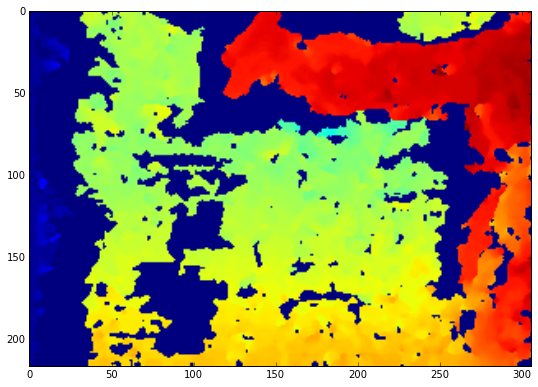

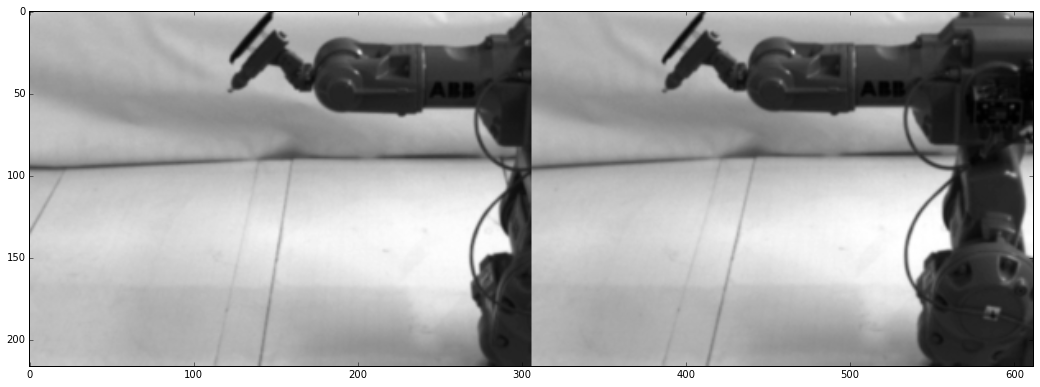

In [21]:
with np.load('data/maps.npz') as X:
    map1L, map2L, map1R, map2R = [X[i] for i in ('arr_0', 'arr_1', 'arr_2', 'arr_3')]

M = 64
w = 3

def stereoSGBM(mindisp=16, sadw=5, p1=42, p2=256, disp12=0, pfiltc=10, unqrat=15, spckw=200, spckr=1):
    imgL = cv2.imread('stereo1/scene/L0296.png')
    imgR = cv2.imread('stereo1/scene/R0296.png')
    imgL = cv2.remap(imgL, map1L, map2L, cv2.INTER_LINEAR)
    imgR = cv2.remap(imgR, map1R, map2R, cv2.INTER_LINEAR)
    imgL = imgL[26:457, 9:621] # Específicos para el mapeo obtenido!
    imgR = imgR[26:457, 9:621]
    
    numdisp = M - mindisp
    w = sadw
    stereo = cv2.StereoSGBM(mindisp, numdisp, sadw, p1, p2, disp12, pfiltc, unqrat, spckw, spckr)
        
    grayL = cv2.cvtColor(imgL,cv2.COLOR_BGR2GRAY)
    grayR = cv2.cvtColor(imgR,cv2.COLOR_BGR2GRAY)
    grayL = cv2.pyrDown(grayL)
    grayR = cv2.pyrDown(grayR)
    
    t_start = t.clock()
    disparity = stereo.compute(grayL,grayR).astype(np.float32)/16.0
    print t.clock() - t_start
    change_figsize(9, 7)
    plt.imshow(disparity)
    plt.show()
    change_figsize(18, 14)
    plt.imshow(np.concatenate((grayL,grayR), axis=1), 'gray')
    plt.show()
    cv2.imwrite('disp.png', disparity)

mindisp_slider = widgets.IntSlider(min=0, max=M-16, step=16, value=0, description='minDisparity')
sadw_slider = widgets.IntSlider(min=1, max=21, step=2, value=5, description='SADWindowSize')
P1_slider = widgets.IntSlider(min=0, max=8*w*w, step=1, value=14, description='P1')
P2_slider = widgets.IntSlider(min=0, max=32*w*w, step=1, value=288, description='P2')
disp12_slider = widgets.IntSlider(min=-1, max=5, step=1, value=0, description='disp12MaxDiff')
pfiltc_slider = widgets.IntSlider(min=0, max=63, step=1, value=10, description='preFilterCap')
unqrat_slider = widgets.IntSlider(min=5, max=15, step=1, value=15, description='uniquenessRatio')
spckw_slider = widgets.IntSlider(min=50, max=200, step=1, value=200, description='speckleWindowSize')
spckr_slider = widgets.IntSlider(min=1, max=2, step=1, value=1, description='speckleRange')
# 0: 16 5 72 288 0 12 10 200 1
# 1: 16 5 14 288 0 10 15 200 1
w = widgets.interactive(stereoSGBM, mindisp=mindisp_slider, sadw=sadw_slider, p1=P1_slider, p2=P2_slider, disp12=disp12_slider,
                        pfiltc=pfiltc_slider, unqrat=unqrat_slider, spckw=spckw_slider, spckr=spckr_slider)

display(w)

In [52]:
ply_header = '''ply
format ascii 1.0
element vertex %(vert_num)d
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
'''

def write_ply(fn, verts, colors):
    verts = verts.reshape(-1, 3)
    colors = colors.reshape(-1, 3)
    verts = np.hstack([verts, colors])
    with open(fn, 'w') as f:
        f.write(ply_header % dict(vert_num=len(verts)))
        np.savetxt(f, verts, '%f %f %f %d %d %d')

        
q2 = np.zeros((3,3))
q2 = Q
q2[0][3] = Q[0][3] / 2
q2[1][3] = -Q[1][3] / 2
q2[2][3] = -Q[2][3]

disp = cv2.imread('disp.png')
disp = cv2.cvtColor(disp,cv2.COLOR_BGR2GRAY)
disp = cv2.pyrUp(disp)
cv2.imwrite('disp2.png', disp)
points = cv2.reprojectImageTo3D(disp, Q)
imgL = cv2.imread('stereo1/scene/L0296.png')
colors = cv2.cvtColor(imgL, cv2.COLOR_BGR2RGB)
imgL = imgL[25:457, 9:621]
mask = disp > disp.min()
out_points = points[mask]
out_colors = colors[mask]
out_fn = 'out.ply'
write_ply('out.ply', out_points, out_colors)

In [53]:
print Q
print q2

[[  1.00000000e+00   0.00000000e+00   0.00000000e+00  -1.69256327e+02]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   1.13301023e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -9.92287281e+02]
 [  0.00000000e+00   0.00000000e+00   8.09518050e-02  -0.00000000e+00]]
[[  1.00000000e+00   0.00000000e+00   0.00000000e+00  -1.69256327e+02]
 [  0.00000000e+00   1.00000000e+00   0.00000000e+00   1.13301023e+02]
 [  0.00000000e+00   0.00000000e+00   0.00000000e+00  -9.92287281e+02]
 [  0.00000000e+00   0.00000000e+00   8.09518050e-02  -0.00000000e+00]]


array([[ 0.,  0.,  0.],
       [ 0.,  0.,  0.],
       [ 0.,  0.,  0.]])